# Exercise 1 - Download, read and visualize H-SAF ASCAT SSM CDR and ISMN data

## Importing packages
Here we first import the python packages which we will need throughout this exercise. Don't worry about the warnings. 

In [1]:
from pathlib import Path

import ascat.h_saf as hsaf  # Package for reading hsaf data
import ascat.read_native.ragged_array_ts as rat
import matplotlib.pyplot as plt  # Plotting library
import numpy as np
import pandas as pd  # noqa
import xarray as xr
from ismn.interface import ISMN_Interface  # Package for reading ISMN data

/home/npikall/miniconda3/envs/dreo/lib/python3.10/site-packages/ascat/h_saf.py:41: UserWarning: pygrib can not be imported GRIB files (H14) can not be read.
  warnings.warn(


## Set paths for data
Here we need to set the paths to where the data is stored. If you have stored all the data to the same folder, you will only need to change the path_test_data variable to your data folder. 

In [4]:
# Set the root path to the data
root = Path("~/Desktop/Data Retrieval in Earth Observation").expanduser()
sync_path = Path("~/shares/radar/DataLab/sync_with_datalab").expanduser()

path_test_data = root / "Data"

# Paths to the different datasets
h120_path = path_test_data / "hsaf"
static_layer_path = path_test_data / "static_layer"
grid_path = path_test_data / "warp5_grid"
ismn_path = root / "ismn"

cell_source = sync_path / "datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
fname = "Data_separate_files_header_20150224_20250224_11904_gvo0_20250224.zip"
data_path = ismn_path / fname


# Check if the paths exist
paths = [path_test_data, h120_path, static_layer_path, grid_path, ismn_path]
for p in paths:
    assert not p.exists()
    print(f"Path exists: {p}")

Path exists: /home/npikall/Desktop/Data Retrieval in Earth Observation/Data
Path exists: /home/npikall/Desktop/Data Retrieval in Earth Observation/Data/hsaf
Path exists: /home/npikall/Desktop/Data Retrieval in Earth Observation/Data/static_layer
Path exists: /home/npikall/Desktop/Data Retrieval in Earth Observation/Data/warp5_grid
Path exists: /home/npikall/Desktop/Data Retrieval in Earth Observation/ismn


## Read ISMN Data

To read ISMN data there is a package available on github, which is already installed here. A description and examples can be found here: https://ismn.readthedocs.io/en/latest/examples/interface.html

In the following cells we give you an example of how to read the data. The first time your data will be unzipped and takes a bit longer. 

In [5]:
# Either a .zip file or one folder that contains all networks
# here we read from .zip
ismn_data = ISMN_Interface(data_path, parallel=False)

OSError: Archive does not exist: /home/npikall/Desktop/Data Retrieval in Earth Observation/ismn/Data_separate_files_header_20150224_20250224_11904_gvo0_20250224.zip

In [6]:
dir(ismn_data)

NameError: name 'ismn_data' is not defined

In [7]:
station_ids = []
lats = []
lons = []

for station in ismn_data.stations_that_measure("soil_moisture"):
    station_ids.append(station.name)
    lats.append(station.lat)
    lons.append(station.lon)

plt.figure(figsize=(6, 6))
plt.scatter(
    lons, lats, marker="o", c="red", edgecolors="black", label="ISMN Stations"
)

for i, station_id in enumerate(station_ids):
    plt.text(lons[i], lats[i], station_id, fontsize=9, ha="right", va="bottom")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("ISMN Station Locations")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'ismn_data' is not defined

In [8]:
# Loop through each station that measures soil moisture
for station in ismn_data.stations_that_measure("soil_moisture"):
    print(f"\n Station '{station.name}' has the following sensors:\n")

    for sensor in station.sensors:
        print(f"   - {sensor}")

    print("_" * 60)  # Separator line for readability

NameError: name 'ismn_data' is not defined

In [9]:
station_id = 54  # integer in the case of this network
ismn_data["WEGENERNET"].stations.get(station_id)

NameError: name 'ismn_data' is not defined

In [10]:
insitu_ds = (
    ismn_data["WEGENERNET"]
    .stations.get(station_id)["Hydraprobe-II_soil_moisture_0.200000_0.200000"]
    .to_xarray()
)
insitu_ds = insitu_ds.squeeze()
insitu_ds

NameError: name 'ismn_data' is not defined

Let's plot the data quickly with the xarray module.

In [11]:
insitu_ds.soil_moisture.plot()

NameError: name 'insitu_ds' is not defined

In [12]:
# let's display metadata in form of dataframe, so it is easier to read
meta = ismn_data["WEGENERNET"].stations.get(station_id).metadata
meta.to_pd()

NameError: name 'ismn_data' is not defined

Save the location information.

In [13]:
lon = ismn_data.metadata.longitude.val
lat = ismn_data.metadata.latitude.val

NameError: name 'ismn_data' is not defined

In [14]:
h120_reader = hsaf.AscatSsmDataRecord(
    cell_source, grid_path=grid_path, static_layer_path=static_layer_path
)
print(h120_reader.path)
h120_ts = h120_reader.read(float(lon.iloc[0]), float(lat.iloc[0]))
h120_ts.head()

RuntimeError: No files found

In [15]:
# convert all backscatter to the dry reference cross over angle of 25
sig25 = (
    h120_ts.sigma40
    + h120_ts.slope40 * (25 - 40)
    + 0.5 * h120_ts.curvature40 * (25 - 40) ** 2.0
)
# get the lowest backscatter
dry_25 = np.percentile(sig25, 5)
# convert to the reference angle of 40
dry_ref = (
    dry_25
    - h120_ts.slope40 * (25 - 40)
    - 0.5 * h120_ts.curvature40 * (25 - 40) ** 2
)
# get the wet reference
wet_ref = np.percentile(h120_ts.sigma40, 95)

# set bare soil sensitivity
lin_bs_sens = 0.21

# convert to linear domain
lin_wet_ref = 10 ** (wet_ref / 10.0)
lin_dry_ref = 10 ** (dry_ref / 10.0)

# get total backscatter sensitivity
lin_sens = lin_wet_ref - lin_dry_ref
inc_angle = -np.cos(np.radians(40)) / 2.0
# calculate vod as ratio between bare soil sensitivity and
# total backscatter sensitivity
# and store it in the h120 dataframe

h120_ts.loc[:, "vod"] = inc_angle * np.log(lin_sens / lin_bs_sens)
# show time series of VOD
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts.loc["2018", "vod"], label="H120 VOD")
ax.set_ylabel(r"VOD (m$^2$/m$^2$)")
ax.legend()
plt.show()

NameError: name 'h120_ts' is not defined

In [16]:
h120_ts.sigma40.plot()

NameError: name 'h120_ts' is not defined

## Read H120 - Metop ASCAT SSM CDR 12.5 km sampling
We need to initialize the reader, where we need to set the paths of the data, the grid file and the static layers. 

Then the data can be read using either longitude and latitude or per gridpoint. You can find the grid of the H120 product here: 
http://rs.geo.tuwien.ac.at/dv/dgg/

The hsaf package automatically reads the data as a pandas dataframe. Now you can use the full functionality of pandas to do a first analysis of your dataset. 
You can have a quick look at the data by using the .head() function, showing you the data structure. For the meaning of the different columns have a look at the Product User Manual: http://hsaf.meteoam.it/documents/PUM/ASCAT_SSM_CDR_PUM_v0.8.pdf
Most important for getting to know the dataset are the columns 'sm'. 

In [17]:
cell_collection = rat.CellFileCollection.from_product_id(
    cell_source, "H121_V1.0"
)

/home/npikall/miniconda3/envs/dreo/lib/python3.10/site-packages/ascat/read_native/ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ascat_ssm_cdr_12' from directory name. Using min/max datetime from files instead.
  warnings.warn(


Let's read the data and plot.

In [18]:
h120_reader = hsaf.AscatSsmDataRecord(
    cell_source, grid_path=grid_path, static_layer_path=static_layer_path
)
print(h120_reader.path)
h120_ts = h120_reader.read(float(lon.iloc[0]), float(lat.iloc[0]))
h120_ts.head()

RuntimeError: No files found

In [19]:
h120_ds = cell_collection.read(
    coords=(float(lon.iloc[0]), float(lat.iloc[0]))
).swap_dims({"obs": "time"})
h120_ds

NameError: name 'lon' is not defined

Let's plot all availalble data for this station's location.

In [20]:
h120_ds.surface_soil_moisture.plot(figsize=(10, 5))

NameError: name 'h120_ds' is not defined

## Plot H120 Soil Moisture data
Now that we have loaded the data we can have a first look at the time series.Soil moisture is available as percentage saturation. If you wish to calculate absolute soil moisture values, a possibility is to multiply the soil moisture data with the porosity value which is stored. 

NameError: name 'h120_ds' is not defined

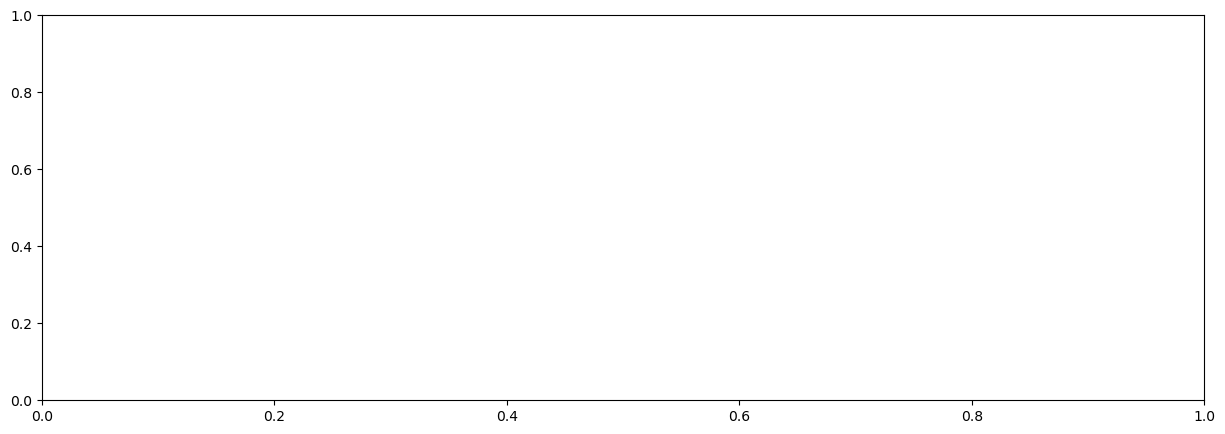

In [21]:
# show complete time series
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ds.surface_soil_moisture, label="H120 SSM")
ax.set_ylabel("Degree of Saturation (%)")
ax.legend()
plt.show()

In [22]:
# Show time series subset

h120_ds_filtered = h120_ds.sel(time=slice("2018-01-01", "2018-12-31"))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ds_filtered.surface_soil_moisture, label="H120 SSM")
ax.set_ylabel("Degree of Saturation (%)")
ax.legend()
plt.show()

NameError: name 'h120_ds' is not defined

As discussed in the live session, soil moisture is affected by snow cover and frozen soils. We can see this in the subset of 2018, where a clear drop in soil moisture is visible in March, which is not likely due to changes in soil moisture. 
Hence we mask for frozen soils and snow cover using the probability mask. Please note, this is not the same as masking using in situ data or model data, but only a probability of that these conditions occur.

## Calculate VOD for exercise 2
In exercise 2 you will need an estimate for TAU or the so-called VOD. TAU can be calculated from Metop ASCAT observables and this is done in the code below. VOD is written to the data frame of the ASCAT data, and when you temporally match the data with the ISMN data then you can store the dataframe including VOD.  

In [23]:
# Convert all backscatter to the dry reference cross over angle of 25 degrees
sig25 = (
    h120_ds.backscatter40
    + h120_ds.slope40 * (25 - 40)
    + 0.5 * h120_ds.curvature40 * (25 - 40) ** 2.0
)

# Get the lowest backscatter (1% in this case)
dry_25 = sig25.quantile(0.01, dim="time")

# Convert to the reference angle of 40 degrees
dry_ref = (
    dry_25
    - h120_ds.slope40 * (25 - 40)
    - 0.5 * h120_ds.curvature40 * (25 - 40) ** 2
)

# Get the wet reference
wet_ref = h120_ds.backscatter40.quantile(0.05, dim="time")

# Set bare soil sensitivity
lin_bs_sens = 0.21

# Convert to linear domain
lin_wet_ref = 10 ** (wet_ref / 10.0)
lin_dry_ref = 10 ** (dry_ref / 10.0)

# Get total backscatter sensitivity
lin_sens = lin_wet_ref - lin_dry_ref
inc_angle = -np.cos(np.radians(40)) / 2.0

# Calculate vod as ratio between bare soil sensitivity
# and total backscatter sensitivity and store it in the h120 xarray
h120_ds["vod"] = inc_angle * np.log(lin_sens / lin_bs_sens)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(
    h120_ds.sel(time=slice("2018-01-01", "2018-12-31")).vod, label="H120 VOD"
)
ax.set_ylabel(r"VOD (m$^2$/m$^2$)")
ax.legend()
plt.show()

NameError: name 'h120_ds' is not defined

## Temporal matching
The data of the in situ station and the satellite observations do not match, e.g. the satellite data is available from 2007 to 2022, the in situ station only since 2014 in my case, the observation times are different with satellite observation irregular between 6 and 10 AM/PM and the in situ data at hourly intervals. So these two datasets need to be matched in time in order to have the same amount of observations. Here it is best practice to match to the most sparse dataset, in our case the ASCAT data.

In [24]:
h120_interp = h120_ds.interp(time=insitu_ds.date_time, method="linear")

plt.figure(figsize=(10, 5))

insitu_ds.soil_moisture.plot(label="In-Situ")

plt.plot(
    h120_interp.date_time,
    h120_interp.surface_soil_moisture / 100,
    label="ASCAT",
)

plt.xlabel("Time")
plt.ylabel("Soil Moisture")
plt.legend()
plt.title("Interpolated ASCAT vs. In-Situ Soil Moisture")
plt.grid()
plt.show()

NameError: name 'h120_ds' is not defined

In [25]:
# Find common date range
start_date = max(insitu_ds.date_time.min(), h120_ds.time.min())
end_date = min(insitu_ds.date_time.max(), h120_ds.time.max())

# Clip datasets to this range
insitu_ds_clipped = insitu_ds.sel(date_time=slice(start_date, end_date))
h120_interp_clipped = h120_interp.sel(date_time=slice(start_date, end_date))

NameError: name 'insitu_ds' is not defined

NameError: name 'insitu_ds_clipped' is not defined

<Figure size 1400x400 with 0 Axes>

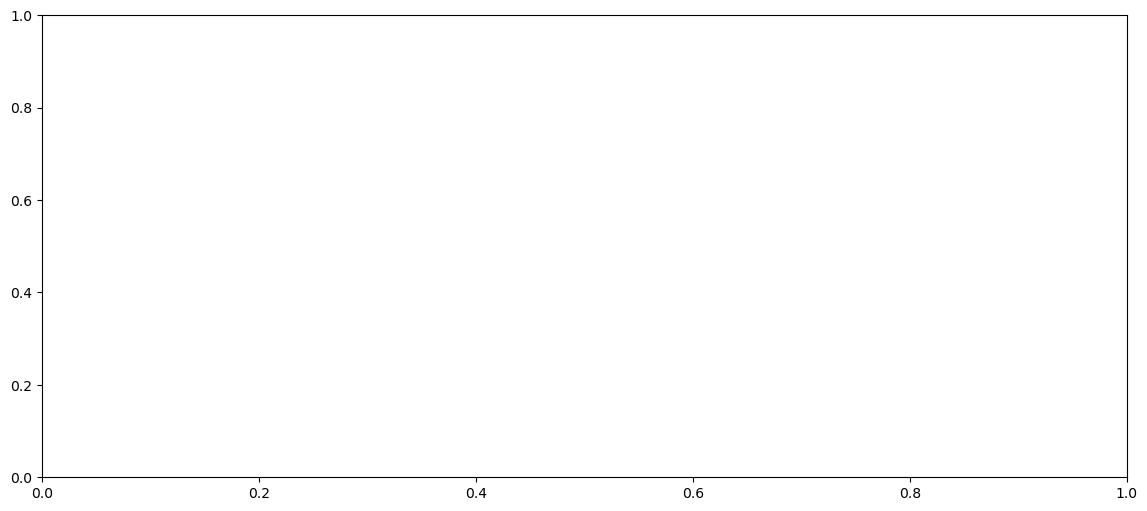

In [26]:
plt.figure(figsize=(14, 4))
fig, ax1 = plt.subplots(figsize=(14, 6))

# In-Situ Soil Moisture in m³/m³
lns1 = ax1.plot(
    insitu_ds_clipped.date_time,
    insitu_ds_clipped.soil_moisture,
    label="In-Situ SM (m³/m³)",
    color="midnightblue",
    marker="o",
    markersize=4,
    linestyle="--",
)
ax1.set_xlabel("Time")
ax1.set_ylabel(r"In-Situ SM (m$^3$/m$^3$)", color="midnightblue")
ax1.tick_params(axis="y", labelcolor="midnightblue")

# ASCAT Soil Moisture in % Degree of Saturation
ax2 = ax1.twinx()
lns2 = ax2.plot(
    h120_interp.date_time,
    h120_interp.surface_soil_moisture,
    label="ASCAT SM (Degree of Saturation %)",
    color="seagreen",
    linestyle="-",
    alpha=0.7,
)
ax2.set_ylabel("ASCAT SM (Degree of Saturation %)", color="seagreen")
ax2.tick_params(axis="y", labelcolor="seagreen")

# Combine Legends from Both Axes
lns = lns1 + lns2
labels = [elem.get_label() for elem in lns]
ax1.legend(lns, labels, loc="upper left")

plt.title("Interpolated ASCAT vs. In-Situ Soil Moisture")
plt.grid()
plt.show()

Keep in mind that all variables are now in one dataset, where soil_moisture stands for in situ data, while sm for ASCAT data. Therefore, we should rename variables for convenience.

In [27]:
merged_ds = xr.merge([insitu_ds.squeeze(), h120_interp]).rename(
    {"soil_moisture": "SM_insitu", "surface_soil_moisture": "SM_ascat"}
)
merged_ds

NameError: name 'insitu_ds' is not defined

Lets save the data to load it for other notebooks. The most convenient format is zarr.

In [ ]:
merged_ds.to_zarr("merged_soilmoisture_vod.zarr", mode="w")

## Exercise
To complete the exercise, please locate an ISMN station of your interest, download the ISMN data, read in the data using the longitude and latitude. Do a temporal matching of the data and plot the time series as shown below and upload this to the Padlet with a description and first interpretation. If necessary, save your matched dataframe (see below) so you have it ready for the other exercises.